In [1]:
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Load the data into a Pandas dataframe
df = pd.read_csv(
    "https://raw.githubusercontent.com/anoop-vs/nlp-climate-change/refs/heads/main/main_data.csv"
)

In [3]:
df

,Unnamed: 0,content,label
0,0,Researchers use deep learning to simulate chlo...,Positive
1,1,Why is our @Conservatives government so evil?\...,Negative
2,2,"Texas Oilfield Waste Company Contributed $53,7...",Negative
3,3,Epic California snowpack is now the deepest it...,Negative
4,4,If #climatechange is real and not a hoax why d...,Negative
...,...,...,...
4405,353,['𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @ team73bit (73bit. com...,Neutral
4406,354,['𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @ team73bit (73bit. com...,Neutral
4407,355,['Motivation direction on how to discover # su...,Positive
4408,356,['𝐃𝐚𝐭𝐚 𝐃𝐫𝐢𝐯𝐞𝐧 𝐃𝐄𝐈 with @ team73bit (73bit. com...,Neutral


In [4]:
df["label"].value_counts()

label
Neutral     1842
Positive    1822
Negative     746
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

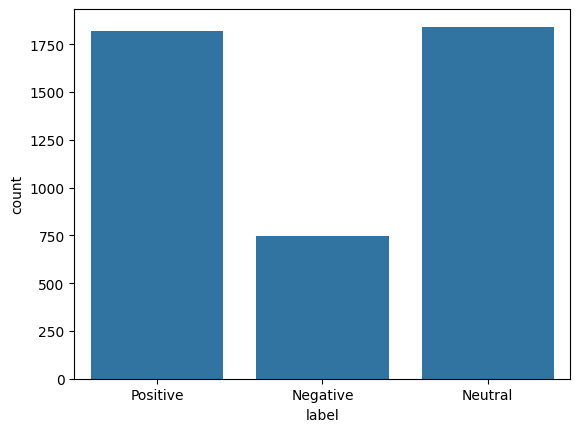

In [5]:
# Create a countplot of the labels
sns.countplot(x="label", data=df)

### **PRE-PROCESSING**


In [6]:
# download stopwords and wordnet lemmatizer
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /Users/nafis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nafis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/nafis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
def preprocess(text):
    # remove special characters and digits
    text = re.sub("[^a-zA-Z]", " ", text)
    # convert to lowercase
    text = text.lower()
    # split into words
    words = text.split()
    # remove stopwords
    stopword_list = set(stopwords.words("english"))
    words = [w for w in words if w not in stopword_list]
    # stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    # join the words back into a string
    text = " ".join(words)
    return text

In [8]:
# apply preprocessing function to the content column
df["content"] = df["content"].apply(preprocess)

In [9]:
df

,Unnamed: 0,content,label
0,0,research use deep learn simul chlorophyl amp p...,Positive
1,1,conserv govern evil rishisunak climatechang co...,Negative
2,2,texa oilfield wast compani contribut regul ove...,Negative
3,3,epic california snowpack deepest decad thank c...,Negative
4,4,climatechang real hoax biden obama gore ocean ...,Negative
...,...,...,...
4405,353,team bit bit com diversityequityinclus dei soc...,Neutral
4406,354,team bit bit com diversityequityinclus dei soc...,Neutral
4407,355,motiv direct discov sustain initi leader organ...,Positive
4408,356,team bit bit com diversityequityinclus dei soc...,Neutral


### OVERSAMPLING


In [10]:
from imblearn.over_sampling import RandomOverSampler

In [11]:
# define the oversampler
oversampler = RandomOverSampler(
    sampling_strategy={"Negative": 1842, "Positive": 1822, "Neutral": 1842}
)

In [12]:
# separate the features and the label
X = df.drop("label", axis=1)
y = df["label"]

In [13]:
# oversample the negative class
X_resampled, y_resampled = oversampler.fit_resample(X, y)


In [14]:
# create the updated dataframe
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

In [15]:
df_resampled

,Unnamed: 0,content,label
0,0,research use deep learn simul chlorophyl amp p...,Positive
1,1,conserv govern evil rishisunak climatechang co...,Negative
2,2,texa oilfield wast compani contribut regul ove...,Negative
3,3,epic california snowpack deepest decad thank c...,Negative
4,4,climatechang real hoax biden obama gore ocean ...,Negative
...,...,...,...
5501,304,gee must terribl peopl ea nooki fellow human b...,Negative
5502,378,intens farm fail u loss biodivers fall nutrit ...,Negative
5503,40,mood alter kill tree studi find great lake ech...,Negative
5504,314,john kerri climateenvoy rich countri must resp...,Negative


In [16]:
df_resampled["label"].value_counts()

label
Negative    1842
Neutral     1842
Positive    1822
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

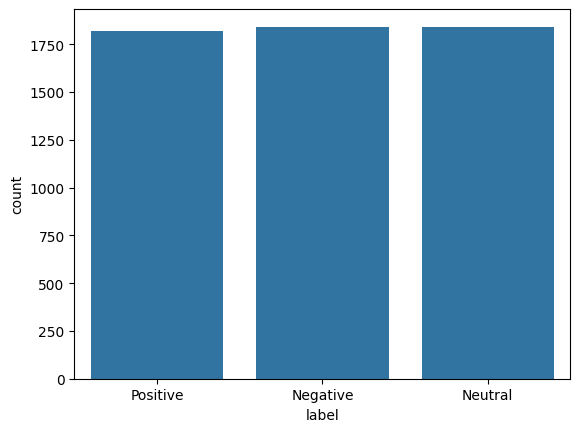

In [17]:
# Create a countplot of the labels
sns.countplot(x="label", data=df_resampled)

In [18]:
X = df_resampled["content"]

In [19]:
X

0       research use deep learn simul chlorophyl amp p...
1       conserv govern evil rishisunak climatechang co...
2       texa oilfield wast compani contribut regul ove...
3       epic california snowpack deepest decad thank c...
4       climatechang real hoax biden obama gore ocean ...
                              ...                        
5501    gee must terribl peopl ea nooki fellow human b...
5502    intens farm fail u loss biodivers fall nutrit ...
5503    mood alter kill tree studi find great lake ech...
5504    john kerri climateenvoy rich countri must resp...
5505    new climat news low impact human recreat chang...
Name: content, Length: 5506, dtype: object

In [20]:
y = df_resampled["label"]

In [21]:
y

0       Positive
1       Negative
2       Negative
3       Negative
4       Negative
          ...   
5501    Negative
5502    Negative
5503    Negative
5504    Negative
5505    Negative
Name: label, Length: 5506, dtype: object

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
# Convert the text data to numerical vectors using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### TFIDF - NaiveBayes


In [24]:
# Train a Naive Bayes classifier on the training data
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB()

In [25]:
# Make predictions on the testing data and compute evaluation metrics
y_pred = clf.predict(X_test_tfidf)

In [26]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.75      0.97      0.84       389
     Neutral       0.87      0.62      0.73       370
    Positive       0.80      0.78      0.79       343

    accuracy                           0.79      1102
   macro avg       0.80      0.79      0.79      1102
weighted avg       0.80      0.79      0.79      1102



### TFIDF - Logistic Regression


In [27]:
logreg = LogisticRegression(C=1000.0, penalty="l2", solver="liblinear")
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(C=1000.0, solver='liblinear')

In [28]:
y_pred = logreg.predict(X_test_tfidf)

In [29]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.91      0.99      0.95       389
     Neutral       0.91      0.83      0.87       370
    Positive       0.89      0.88      0.88       343

    accuracy                           0.90      1102
   macro avg       0.90      0.90      0.90      1102
weighted avg       0.90      0.90      0.90      1102



In [30]:
# Train a random forest classifier on the training data
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [31]:
# Make predictions on the testing data and compute evaluation metrics
y_pred = rfc.predict(X_test_tfidf)

In [32]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.91      0.98      0.94       389
     Neutral       0.90      0.81      0.85       370
    Positive       0.84      0.85      0.85       343

    accuracy                           0.88      1102
   macro avg       0.88      0.88      0.88      1102
weighted avg       0.88      0.88      0.88      1102



### TFIDF - DECISION TREE


In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid (match original)
param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
}

# Create a Decision Tree Classifier object
dtc = DecisionTreeClassifier(random_state=42)

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packag

Best hyperparameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score:  0.7141185120214633


/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [34]:
# Initialize a decision tree model with original parameters
dt_model = DecisionTreeClassifier(
    max_depth=None, max_features="auto", min_samples_leaf=1, min_samples_split=2
)

# Fit the model on the training data
dt_model.fit(X_train_tfidf, y_train)

# Predict the target variable on the testing data
y_pred = dt_model.predict(X_test_tfidf)

# Calculate the accuracy score of the model on the testing data
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

Accuracy: 0.7631578947368421


/Users/nafis/code/python/climate change sentiment analysis/.venv311/lib/python3.11/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [35]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.83      0.93      0.88       389
     Neutral       0.74      0.63      0.68       370
    Positive       0.70      0.71      0.71       343

    accuracy                           0.76      1102
   macro avg       0.76      0.76      0.76      1102
weighted avg       0.76      0.76      0.76      1102



### TFIDF - SVM


In [36]:
# Create SVM classifier object
classifier = SVC(kernel="linear")

# Train SVM classifier
classifier.fit(X_train_tfidf, y_train)

# Predict target values for testing set
y_pred = classifier.predict(X_test_tfidf)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy score
print("Accuracy:", accuracy)

Accuracy: 0.8475499092558983


In [37]:
from sklearn.metrics import classification_report

# assuming y_true and y_pred are arrays of true and predicted labels respectively
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

    Negative       0.89      0.96      0.92       389
     Neutral       0.83      0.74      0.78       370
    Positive       0.82      0.84      0.83       343

    accuracy                           0.85      1102
   macro avg       0.84      0.85      0.84      1102
weighted avg       0.85      0.85      0.85      1102

